<h1 style="text-align: center; font-weight: bold;">
    Χρήστος-Αλέξανδρος Δαρδαμπούνης ΑΕΜ:10335<br>
    Χρήστος Κούνσολας ΑΕΜ:10345
</h1>

In [1]:
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch import nn, optim

In [2]:
# Importing the dataset
train_data = pd.read_csv('datasetTV.csv', header=None) 
train_data.shape 
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
count,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,...,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000
mean,0.360086,0.001636,0.343860,0.177411,0.199805,0.522868,0.374971,0.515616,0.041620,-0.002033,...,0.039921,0.236045,0.017460,-0.000181,0.099152,0.589612,0.293870,0.505508,0.336356,3.002974
std,0.545784,0.321264,0.537970,0.479141,0.469726,0.559579,0.552721,0.559624,0.359096,0.315393,...,0.363500,0.499744,0.334342,0.315676,0.422491,0.557340,0.526766,0.566306,0.539380,1.420828
min,-1.052900,-1.492000,-1.168500,-1.154900,-1.238800,-1.170100,-1.107700,-1.100400,-1.099600,-1.250200,...,-1.135700,-1.425500,-1.293200,-1.204800,-1.247600,-0.996050,-1.199500,-1.128500,-1.262700,1.000000
25%,-0.056065,-0.212760,-0.059468,-0.154845,-0.121140,0.075904,-0.055405,0.067974,-0.199340,-0.215180,...,-0.196505,-0.124815,-0.200560,-0.212570,-0.181110,0.150170,-0.092223,0.047072,-0.066114,2.000000
50%,0.273600,0.004490,0.254900,0.102000,0.126890,0.520860,0.289280,0.502110,0.022291,-0.003436,...,0.020447,0.142230,0.010184,-0.003301,0.058561,0.632400,0.200250,0.491010,0.244160,3.000000
75%,0.772390,0.212595,0.739950,0.428225,0.449460,0.962550,0.813090,0.970790,0.257875,0.215170,...,0.248805,0.524955,0.224765,0.216025,0.315955,1.034800,0.658455,0.975250,0.737990,4.000000
max,2.035000,1.582200,2.075400,1.928000,1.934200,2.274400,2.256800,2.219700,1.694600,1.177000,...,1.841900,2.091700,1.896100,1.327000,2.203600,2.311800,2.306800,2.106100,2.272200,5.000000


In [3]:
X, y = train_data.iloc[:, :224].values, train_data.iloc[:, 224].values # get the features and labels
X.shape, y.shape

((8743, 224), (8743,))

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # split the data into training and validation sets
model_results = [] # list to store the results of the models

# **Helper Functions**

In [13]:
# function to evaluate the model
def evaluate_model(model, y_val, y_pred):
    report = {}

    report['accuracy'] = accuracy_score(y_val, y_pred) # calculate the accuracy
    model_results.append(report['accuracy'] * 100) # append the accuracy to the model_results list
    report['confusion_matrix'] = confusion_matrix(y_val, y_pred)
    conf_mat = report['confusion_matrix']
    if hasattr(model, 'classes_'): # check if the model has the classes_ attribute
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=np.unique(y_val))
    disp.plot()
    plt.show()
    print(f'Accuracy : {report["accuracy"]*100:.4f}%') # print the accuracy

    return report

# function to create a bar chart
def create_bar_chart(names, model_results, colors=None): 
    plt.bar(names, model_results, color=colors, width=0.5) # create a bar chart
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.title('Model Accuracy')
    plt.tight_layout()
    plt.show()

def train_test_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train) # train the model
    y_pred = model.predict(X_val) # make predictions
    return evaluate_model(model, y_val, y_pred)

def save_model(model, filename): # save the model to a file
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename): # load the model from a file
    with open(filename, 'rb') as file:
        return pickle.load(file)

# **Grid Search for the Best SVM**

In [31]:
param_grid = [
    # RBF kernel
    {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "kernel": ["rbf"],
        "gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1, "scale", "auto"],
        "shrinking": [True, False],
        "cache_size": [200, 500],  # Allows tuning for memory usage
    },
    # Polynomial kernel
    {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "kernel": ["poly"],
        "degree": [2, 3, 4, 5],
        "gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1, "scale", "auto"],
        "coef0": [0.0, 0.1, 0.5, 1, 2],
        "shrinking": [True, False],
        "cache_size": [200, 500],  # Allows larger memory for bigger datasets
    }
]


model_svm = SVC()

grid_search = GridSearchCV(model_svm, param_grid, cv=10, n_jobs=-1, verbose=2) # create a grid search object
grid_search.fit(X_train, y_train) # fit the grid search object to the training data

Fitting 10 folds for each of 4116 candidates, totalling 41160 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'cache_size': [200, 500],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale',
                                    'auto'],
                          'kernel': ['rbf'], 'shrinking': [True, False]},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'cache_size': [200, 500],
                          'coef0': [0.0, 0.1, 0.5, 1, 2],
                          'degree': [2, 3, 4, 5],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale',
                                    'auto'],
                          'kernel': ['poly'], 'shrinking': [True, False]}],
             verbose=2)

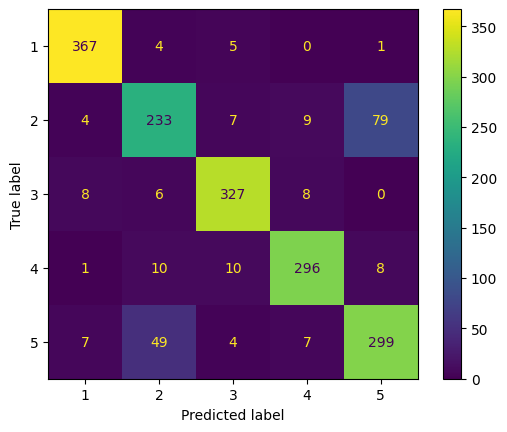

Accuracy : 87.0212%


In [30]:
y_preds = best_model_svm.predict(X_val) # make predictions
report_svm = evaluate_model(best_model_svm, y_val, y_preds)

# **Bootstrap(Feature Bagging) with Decision Tree**

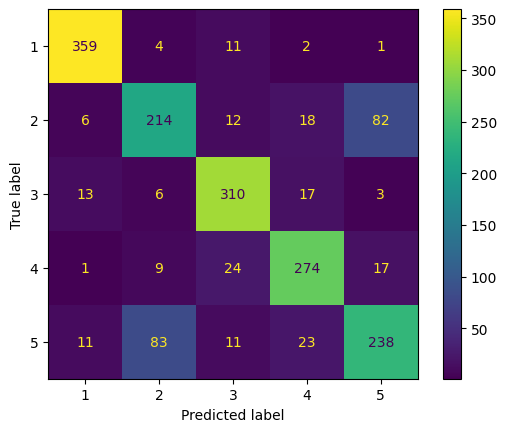

Accuracy : 79.7599%


In [31]:
model_boot_tree = DecisionTreeClassifier() # create a decision tree model

model_boot = BaggingClassifier(model_boot_tree, n_estimators=1000, random_state=42, max_samples=1.0, bootstrap=True, n_jobs=-1) # create a bagging classifier model
report_boot = train_test_model(model_boot, X_train, y_train, X_val, y_val) # train and test the model

# **Bootstrap(Feature Bagging) with the Best SVM**

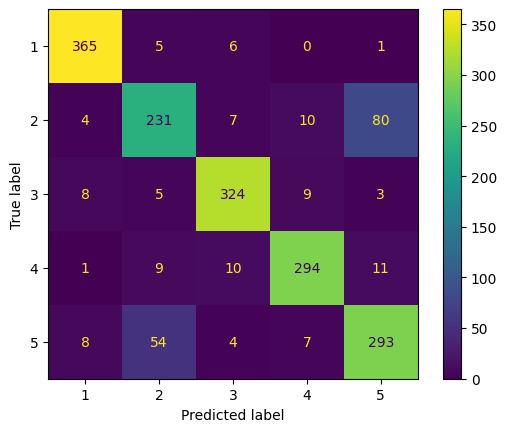

Accuracy : 86.1635%


In [32]:
model_boot_svm = BaggingClassifier(best_model_svm, n_estimators=300, random_state=42, max_samples=1.0, bootstrap=True, n_jobs=-1) # create a bagging classifier model
report_boot_svm = train_test_model(model_boot_svm, X_train, y_train, X_val, y_val)

# **Bagging Classifier for the Best SVM**

In [22]:
param_grid = {
    "n_estimators": [ 300, 500],
    "max_samples" : [0.5, 0.7, 1.0],
    "max_features" : [0.5, 0.7, 1.0],
} # create a parameter grid

model_grid_bag = BaggingClassifier(best_model_svm, random_state=42, bootstrap=True, n_jobs=-1) # create a bagging classifier model
grid_search = GridSearchCV(model_grid_bag, param_grid, cv=10, n_jobs=-1, verbose=2) # create a grid search object
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10,
             estimator=BaggingClassifier(estimator=SVC(C=1, coef0=0.1,
                                                       kernel='poly'),
                                         n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.7, 1.0],
                         'n_estimators': [300, 500]},
             verbose=2)

In [26]:
best_svm_bag_params = grid_search.best_params_ # get the best parameters
best_svm_bag_model  = grid_search.best_estimator_ # get the best model from the bagging classifier
save_model(best_svm_bag_model, 'best_svm_bag_model.pkl') # save the best model
save_model(best_svm_bag_params, 'best_svm_bag_params.pkl') # save the best parameters

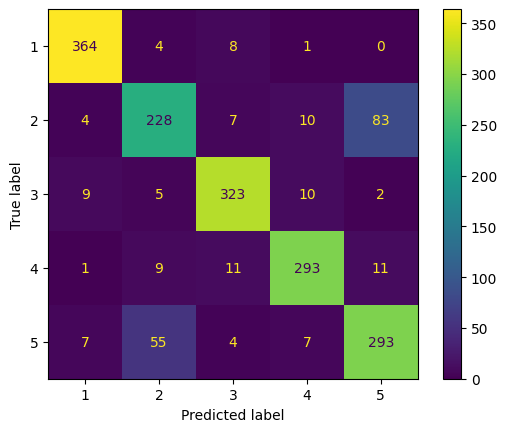

Accuracy : 85.8205%


In [33]:
y_preds = best_svm_bag_model.predict(X_val) # get the predictions
report_svm_bag = evaluate_model(best_svm_bag_model, y_val, y_preds) # evaluate the model

# **Simple Logistic Regression Model**

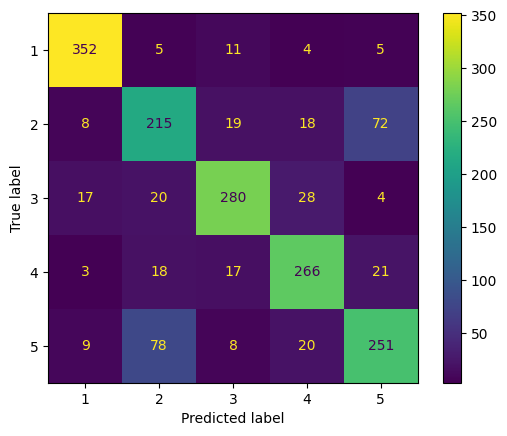

Accuracy : 77.9874%


In [47]:
model_log_reg = LogisticRegression(random_state=42, max_iter=1000) # create a logistic regression model
report_log_reg = train_test_model(model_log_reg, X_train, y_train, X_val, y_val) # train and test the model

# **Logistic Regression with Bootstrap**

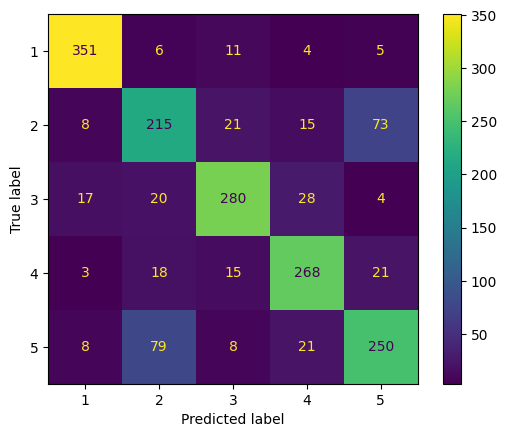

Accuracy : 77.9874%


In [49]:
model_log_reg_bag = BaggingClassifier(model_log_reg, n_estimators=1000, random_state=42, max_samples=1.0, bootstrap=True, n_jobs=-1) # create a bagging classifier model
report_log_reg_bag = train_test_model(model_log_reg_bag, X_train, y_train, X_val, y_val)

# **Grid Search Logistic Regression**

In [51]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200, 500, 1000]
} # create a parameter grid

model_grid_log_reg = LogisticRegression(random_state=42) # create a logistic regression model
grid_search = GridSearchCV(model_grid_log_reg, param_grid, cv=10, n_jobs=-1, verbose=2) # create a grid search object
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [200, 500, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=2)

In [52]:
best_log_reg_params = grid_search.best_params_  # get the best parameters
best_log_reg_model = grid_search.best_estimator_ # get the best model from the grid search
save_model(best_log_reg_model, 'best_log_reg_model.pkl')
save_model(best_log_reg_params, 'best_log_reg_params.pkl')

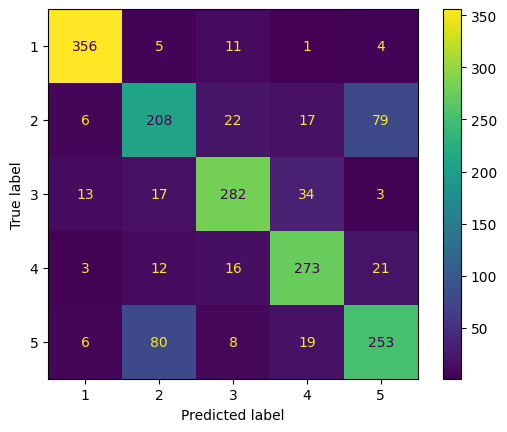

Accuracy : 78.4448%


In [53]:
y_preds = best_log_reg_model.predict(X_val) # get the predictions
report_log_reg_grid = evaluate_model(best_log_reg_model, y_val, y_preds)

# **Grid Search Boosting**

## Use PCA applied samples

In [36]:
pca = PCA(n_components=0.92) # create a PCA object
scaler = StandardScaler() # create a standard scaler object
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)

X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)

print(f"Original shape: {X_train_sc.shape}, PCA shape: {X_train_pca.shape}") # print the shapes of the original and PCA transformed data

Original shape: (6994, 224), PCA shape: (6994, 172)


In [37]:
boosting_model_clf = AdaBoostClassifier(random_state=42) # create an AdaBoost classifier model

param_grid = {
    "n_estimators": [100, 250, 400, 650, 1000],
    "learning_rate": [0.01, 0.1, 0.5, 1, 1.5, 2],
    "algorithm": ["SAMME", "SAMME.R"]
} # create a parameter grid

grid_search_boosting = GridSearchCV(boosting_model_clf, param_grid, cv=10, n_jobs=-1, verbose=2) # create a grid search object

grid_search_boosting.fit(X_train_pca, y_train)


Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.1, 0.5, 1, 1.5, 2],
                         'n_estimators': [100, 250, 400, 650, 1000]},
             verbose=2)

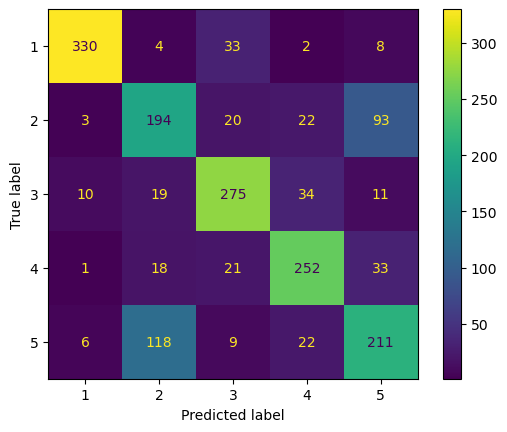

Accuracy : 72.1555%


In [65]:
best_boosting_params = grid_search_boosting.best_params_
best_boosting_model = grid_search_boosting.best_estimator_
y_preds = best_boosting_model.predict(X_val_pca) # get the predictions
report_boosting = evaluate_model(best_boosting_model, y_val, y_preds) # evaluate the model

In [46]:
save_model(best_boosting_model, 'best_boosting_model.pkl')
save_model(best_boosting_params, 'best_boosting_params.pkl')

# **Grid Search Random Forest**

In [39]:
param_grid = {
    "n_estimators": [400, 500, 1000],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 5],
    "max_samples": [0.5, 0.7,1.0]   
} # create a parameter grid


random_forest_clf = RandomForestClassifier() # create a random forest classifier model

grid_search = GridSearchCV(random_forest_clf, param_grid, cv=5, n_jobs=-1, verbose=2) # create a grid search object

grid_search.fit(X_train_pca, y_train) # fit the grid search object to the training data

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.5, 0.7, 1.0],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [400, 500, 1000]},
             verbose=2)

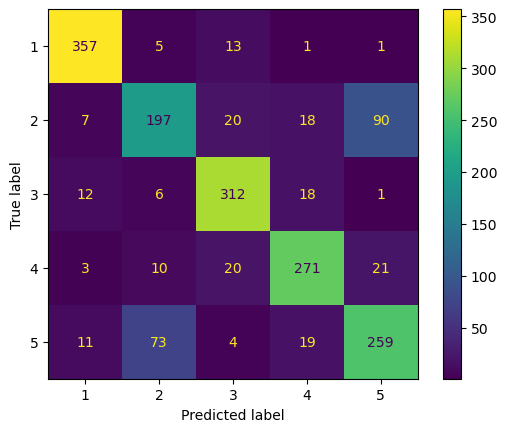

Accuracy : 79.8170%


In [66]:
best_randomForest_params = grid_search.best_params_
best_random_forest_model = grid_search.best_estimator_
y_preds = best_random_forest_model.predict(X_val_pca) # get the predictions
report_randomForest = evaluate_model(best_random_forest_model, y_val, y_preds) # evaluate the model

In [45]:
save_model(best_random_forest_model, 'best_randomForest_model.pkl')
save_model(best_randomForest_params, 'best_randomForest_params.pkl')

# **Neural Network**

In [6]:
# create a scikit learn wrapper for the PyTorch MLP
class PyTorchMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device, learning_rate, epochs, momentum, classes=None, weight_decay=1e-4, class_weights=None, reduction='mean'):
        self.model = model
        self.device = device
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.class_weights = class_weights
        self.reduction = reduction
        self.classes = classes
        # self.X_train = torch.from_numpy(X_train).to(self.device).type(torch.float32)
        # self.y_train = torch.from_numpy(y_train).to(self.device).type(torch.long) - 1
        # self.X_test = torch.from_numpy(X_test).to(self.device).type(torch.float32)
        # print(y_test)
        # self.y_test = torch.from_numpy(y_test).to(self.device).type(torch.long) - 1

    def fit(self,X_train,y_train):  

        self.classes = np.unique(y_train) 
        X_train_tensor = torch.from_numpy(X_train).to(self.device).type(torch.float32)
        
        y_train_tensor = torch.from_numpy(y_train).to(self.device).type(torch.long) - 1
        
        
        #put model to the gpu if available
        self.model = self.model.to(self.device)

        self.class_weights = torch.tensor(self.class_weights).to(self.device).type(torch.float32)
        #define the loss function and the optimizer
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights, reduction=self.reduction) #because i have multiple classes
        optimizer = optim.SGD(self.model.parameters(),lr=self.learning_rate,momentum=self.momentum,weight_decay=self.weight_decay) #check memomtum and other optimizers


        #train the model
        for epoch in range(self.epochs):
            self.model.train()
            #forward pass   
            y_logits = self.model(X_train_tensor)
            #calculate the loss
            loss = loss_fn(y_logits,y_train_tensor)
            #optimizer zero grad
            optimizer.zero_grad()
            #loss backwards
            loss.backward()
            #optimizer step
            optimizer.step()

        return self
    
    def predict(self, X_test):
            
            X_test_tensor = torch.from_numpy(X_test).to(self.device).type(torch.float32) #convert the test data to tensor
            # y_test_tensor = torch.from_numpy(y_test).to(self.device).type(torch.long) - 1

            # put model to evaluation mode
            self.model.eval()
            with torch.inference_mode(): # turn off the gradient computation
                y_preds = self.model(X_test_tensor)
                y_preds = torch.argmax(y_preds,dim=1)
                # acc = accuracy_score(self.y_test.cpu() + 1,y_preds.cpu() + 1) * 100
                # print(f"Accuracy: {acc:.4f} %")
                # print(np.unique(y_preds.cpu().numpy() + 1))
                return y_preds.cpu().numpy() + 1
            
    # predict the probabilities
    def predict_proba(self, X_test):
        X_test_tensor = torch.from_numpy(X_test).to(self.device).type(torch.float32)
        self.model.eval()
        with torch.inference_mode():
            y_logits = self.model(X_test_tensor)
            y_probs = torch.softmax(y_logits, dim=1)
        return y_probs.cpu().numpy()

In [7]:
class MLP(nn.Module): # create a PyTorch MLP model
    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_units), # input layer
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_size), # hidden layer
        )

    def forward(self, x):
        return self.layer(x)

C:\Users\chris\AppData\Local\Temp\ipykernel_4768\965556982.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(self.class_weights).to(self.device).type(torch.float32)


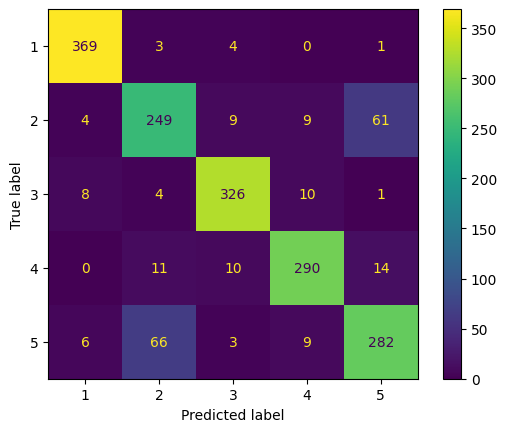

Accuracy : 86.6781%


In [67]:
mlp_model = MLP(input_size=X_train.shape[1], hidden_units=2048, output_size=5) # create the MLP model

# Wrap the PyTorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_mlp = PyTorchMLPClassifier(mlp_model, device, epochs=50001,learning_rate=0.05,momentum=0.9, class_weights=torch.tensor([1.0, 3, 1.0, 1.0, 3])) # create the PyTorch MLP classifier


# pytorch_mlp.fit(X_train, y_train)
report_neural = train_test_model(pytorch_mlp, X_train, y_train, X_val, y_val) # train and test the model

# **K-Nearest Neighbour**

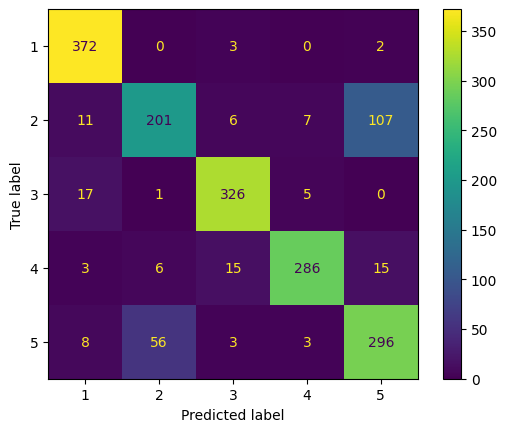

Accuracy : 84.6770%


In [9]:
kNN = KNeighborsClassifier(n_neighbors=7) # create a kNN model
report_kNN = train_test_model(kNN, X_train, y_train, X_val, y_val) # train and test the model

# **K-Nearest Neighbour Grid Search**

In [11]:
param_grid = {
    "n_neighbors": [3, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
} # create a parameter grid

grid_search_kNN = GridSearchCV(kNN, param_grid, cv=10, n_jobs=-1, verbose=2) # create a grid search object
grid_search_kNN.fit(X_train, y_train) # fit the grid search object to the training data

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=7), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=2)

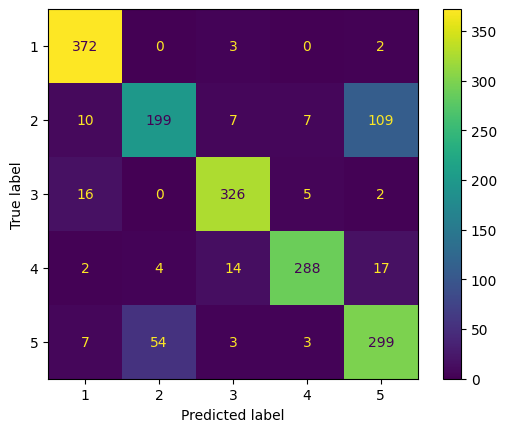

Accuracy : 84.8485%


In [14]:
best_knn_params = grid_search_kNN.best_params_
best_knn_model = grid_search_kNN.best_estimator_
y_preds = best_knn_model.predict(X_val) # get the predictions
report_kNN = evaluate_model(best_knn_model, y_val, y_preds) # evaluate the model

# **Model Stacking**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier # import the OneVsRestClassifier class

scaler = StandardScaler() # create a standard scaler object
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
# Example for class 2
binary_svm_2 = OneVsRestClassifier(SVC(probability=True, random_state=42, kernel='poly', coef0=0.1, C=1.0, degree=3)) # create a binary SVM model
binary_svm_2.fit(X_train_scaled, (y_train == 2).astype(int)) # fit the model, y_train == 2 will return a boolean array, which is then converted to an integer array

# Example for class 5
binary_svm_5 = OneVsRestClassifier(SVC(probability=True, random_state=42, kernel='poly', coef0=0.1, C=1.0, degree=3)) # create a binary SVM model
binary_svm_5.fit(X_train_scaled, (y_train == 5).astype(int)) # fit the model, y_train == 5 will return a boolean array, which is then converted to an integer array

OneVsRestClassifier(estimator=SVC(coef0=0.1, kernel='poly', probability=True,
                                  random_state=42))

In [ ]:
mlp_model2 = MLPClassifier(hidden_layer_sizes=(1120, 1120), max_iter=1000, random_state=42, activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', learning_rate_init=0.001, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=0.0001, verbose=False)

# Example: Hyperparameter tuning for MLPClassifier
mlp_params = {
    'hidden_layer_sizes': [(1120, 1120), (512, 512), (256, 256)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 1500, 2000]
} # create a parameter grid

random_search_mlp = RandomizedSearchCV(
    estimator=mlp_model2,
    param_distributions=mlp_params,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
) # create a random search object

random_search_mlp.fit(X_train, y_train) # fit the random search object to the training data
best_mlp = random_search_mlp.best_estimator_ # get the best model

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BaggingClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Logis

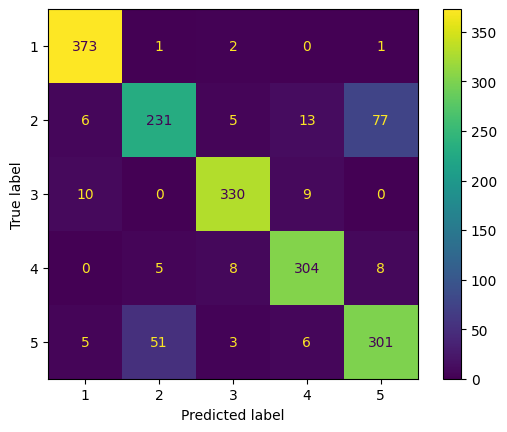

Accuracy : 87.9931%


In [15]:
best_svm = load_model('best_model_svm.pkl')
best_svm_bag = load_model('best_svm_bag_model.pkl')
best_log_reg = load_model('best_log_reg_model.pkl')
best_knn = load_model('best_knn_model.pkl')
best_mlp = load_model('best_model_mlp.pkl')
mlp_model2 = MLPClassifier(hidden_layer_sizes=(1120, 1120), max_iter=1000, random_state=42, activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', learning_rate_init=0.001, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=0.0001, verbose=False)


estimators = [
    ('svm', best_svm), # add the best SVM model 
    ('svm_bag', best_svm_bag), # add the best bagging SVM model
    ('log_reg', best_log_reg), # add the best logistic regression model
    ('knn', best_knn), # add the best kNN model
    ("xgb", xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)), # add the XGBoost model
    ("mlp", mlp_model2), # add the best MLP model
    ('binary_svm_2', binary_svm_2), # add the binary SVM model for class 2
    ('binary_svm_5', binary_svm_5), # add the binary SVM model for class 5
]



stacking_model = StackingClassifier(estimators=estimators, final_estimator=best_mlp, cv=10, n_jobs=-1) # create a stacking classifier model
report_stacking = train_test_model(stacking_model, X_train, y_train, X_val, y_val) # train and test the model

# **Εισαγωγή βαρών για τις κλάσεις**

In [99]:
from sklearn.utils.class_weight import compute_class_weight

# Define the classes present in y_train
classes = np.unique(y_train) - 1

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train - 1)

# Create a dictionary mapping classes to their corresponding weights
class_weights_dict = dict(zip(classes, class_weights))

print("Computed class weights:", class_weights_dict)

Computed class weights: {0: 1.0048850574712644, 1: 1.0077809798270894, 2: 0.9955871886120996, 3: 1.005607476635514, 4: 0.9864598025387871}


# **Second Stacking Model**

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BaggingClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Logis

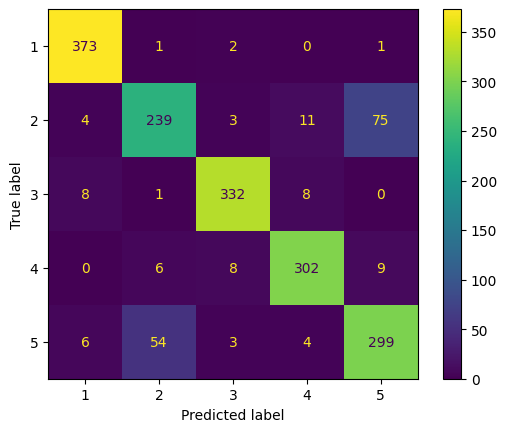

Accuracy : 88.3362%


In [100]:
best_svm = load_model('best_model_svm.pkl') # load the best SVM model
best_svm_bag = load_model('best_svm_bag_model.pkl') # load the best bagging SVM model
best_log_reg = load_model('best_log_reg_model.pkl') # load the best logistic regression model
best_knn = load_model('best_knn_model.pkl') # load the best kNN model
best_mlp = load_model('best_model_mlp.pkl') # load the best MLP model
mlp_model2 = MLPClassifier(hidden_layer_sizes=(1120, 1120), max_iter=1000, random_state=42, activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', learning_rate_init=0.001, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, tol=0.0001, verbose=False)

best_svm.set_params(class_weight=class_weights_dict)
best_log_reg.set_params(class_weight=class_weights_dict)
best_knn.set_params(weights='distance')  # Alternative weighting for KNN

estimators = [
    ('svm', best_svm), # add the best SVM model
    ('svm_bag', best_svm_bag), # add the best bagging SVM model
    ('log_reg', best_log_reg), # add the best logistic regression model
    ('knn', best_knn), # add the best kNN model
    ("xgb", xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)), # add the XGBoost model
    ("mlp", mlp_model2), # add the best MLP model
    ('binary_svm_2', binary_svm_2), # add the binary SVM model for class 2
    ('binary_svm_5', binary_svm_5), # add the binary SVM model for class 5
    ("rf", RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, bootstrap=False, class_weight=class_weights_dict)), # add the random forest model
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=best_mlp, cv=10, n_jobs=-1) # create a stacking classifier model
report_stacking = train_test_model(stacking_model, X_train, y_train, X_val, y_val) # train and test the model

# **Creating The Bar Chart for all our models**

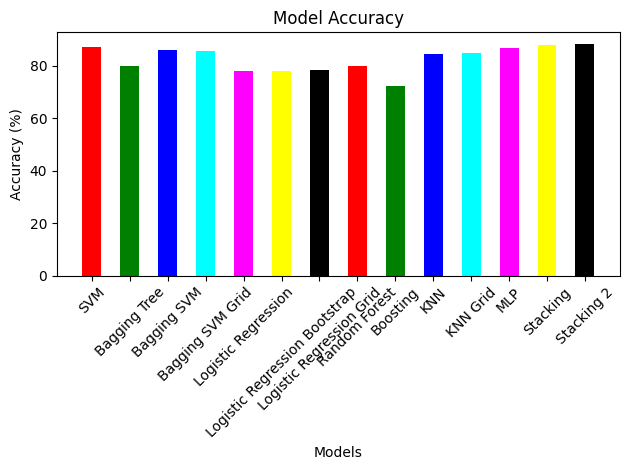

In [25]:
names = ['SVM', 'Bagging Tree', 'Bagging SVM', 'Bagging SVM Grid', 'Logistic Regression', 'Logistic Regression Bootstrap', 'Logistic Regression Grid', 'Random Forest', 'Boosting', 'KNN', 'KNN Grid', 'MLP', 'Stacking', 'Stacking 2']
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']
create_bar_chart(names, model_results, colors)

In [107]:
final_model = load_model('best_stacking_model2.pkl') # load the best stacking model

In [9]:
X_test = pd.read_csv('datasetTest.csv', header=None).iloc[:, :224].values # load the test data

In [108]:
final_model.fit(X, y) # train the final model on the entire dataset

StackingClassifier(cv=10,
                   estimators=[('svm',
                                SVC(C=1,
                                    class_weight={0: 1.0048850574712644,
                                                  1: 1.0077809798270894,
                                                  2: 0.9955871886120996,
                                                  3: 1.005607476635514,
                                                  4: 0.9864598025387871},
                                    coef0=0.1, kernel='poly')),
                               ('svm_bag',
                                BaggingClassifier(estimator=SVC(C=1, coef0=0.1,
                                                                kernel='poly'),
                                                  max_features=0.5,
                                                  n_estimators=500, n_jobs=-1,
                                                  random_state=42)),
                               ('log_reg',
                                Logistic...
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight={0: 1.0048850574712644,
                                                                     1: 1.0077809798270894,
                                                                     2: 0.9955871886120996,
                                                                     3: 1.005607476635514,
                                                                     4: 0.9864598025387871},
                                                       n_estimators=1000,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=MLPClassifier(early_stopping=True,
                                                 hidden_layer_sizes=(512, 512),
                                                 learning_rate='adaptive',
                                                 max_iter=1000,
                                                 random_state=42),
                   n_jobs=-1)

In [111]:
y_preds = final_model.predict(X_test) # get the predictions

In [114]:
np.save('labels22.npy', y_preds) # save the predictions to a file

In [115]:
predictions = np.load('labels22.npy') # load the predictions from the file